# Bonus Questions for more in-depth OpenMP 

In this notebook we will explore some of the more advanced concepts surrounding openMP. Note that not all of these are critical to speed up weather and climate codes so they are structured in this bonus notebook

## Parallel Execution Time

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B1: Assume you have a program hat is 99% parallelizeable. If we parallelize it but by parallelizing we add parallel overhead to the code (by adding communication). The overhead is at $0.0001 \cdot \log(n)$ runtime. How many nodes are the ideal configuration for this to run as fast as possible?
</div>

In [19]:
import numpy as np
import math

cores = [None] #TODO
run_time = [None] #TODO
index_min = np.argmin(run_time)
print(index_min)


0


In [16]:
import numpy as np
import math

cores = range(1,70000) # TODO
run_time = [0.1+0.99/x+0.0001*math.log(x) for x in cores] # TODO
index_min = np.argmin(run_time)
print(index_min)


9899


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B2: Can we mathemathically prove that this is actually ideal?
    </div>

## Amdahl's Law

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B3: Assume you have a program hat is 99% parallelizeable. If you have three machnies available, your laptop with 8 cores, all the fat-nodes of Brutus (3840 corers) and the full CPU partition of Piz Daint with it's 65268 cores. How much speedup do these machines offer you?
    </div>

In [1]:
cores = [] # TODO
run_time = [] # TODO
speedup = [] # TODO
print(speedup)


[]


In [2]:
cores = [1, 8,3840,65268] # TODO
run_time = [0.1 + 0.99/x for x in cores] # TODO
speedup = [run_time[0]/x for x in run_time] # TODO
print(speedup)


[1.0, 4.871508379888269, 10.871970700537677, 10.89834691373344]


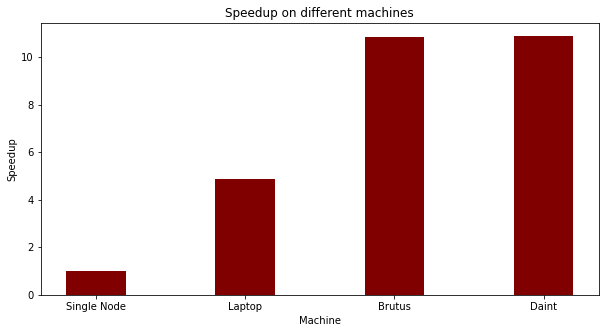

In [10]:
import matplotlib.pyplot as plt

# creating the dataset
courses = ["Single Node", "Laptop", "Brutus", "Daint"]
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, speedup, color ='maroon',
        width = 0.4)
 
plt.xlabel("Machine")
plt.ylabel("Speedup")
plt.title("Speedup on different machines")
plt.show()

# Exploration of intrinsics

In this section we are exploring the difference in speed between various intinsics

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B4: Write a program <code>expensive.cpp</code> where we loop over $n$ iteration and take the $arccos$ of the $cos$ of the $arcsin$ of the $sin$ of the $abs$ value of it's iteration number divided by the total number of iterations.

</div>
We sum all these values up and verify correctness by printing the result.
Ideally the program is parametrized with the number of iterations as well as the number of threads used.


In [3]:
%%bash
make clean

rm -f parallel private reduction regions schedule scoping shared threadnum timing weak weak.txt barrier barrier2 caching.txt caching2 caching2.txt infos loops nowait out.txt caching 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt


In [11]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

CC expensive.cpp -fopenmp -o expensive.x -O3

In [12]:
%%bash
srun -n 1 ./expensive.x 1 10

4.5


This call should print a value of 4.5

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B5: Duplicate the file into a file called <code>critical.cpp</code> Parallelize the for loop and make the updates work in critical secions.
How much speedup do we get?
</div>    

In [18]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

CC critical.cpp -fopenmp -o critical.x -O3

In [20]:
%%bash
srun -n 1 ./critical.x 12 1000

12 0.0134138


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B6: Duplicate the file into a file called <code>atomic.cpp</code> update the critical section to use an atomic instead.
How much speedup do we get?
</div>    

In [23]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

CC atomic.cpp -fopenmp -o atomic.x -O3

In [3]:
%%bash
srun -n 1 ./atomic.x 12 1000

12 0.000491527


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B7: Duplicate the file into a file called <code>reduction.cpp</code> and change the loop to use the intrinsic reduction. How do times compare between the reduction and the atomic?
</div>

In [8]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

CC reduction.cpp -fopenmp -o reduction.x -O3

In [10]:
%%bash
srun -n 1 ./reduction.x 12 1000

12 0.000456981


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B8: Lastly we try to completely parallelize the code and have a single thread sum up the result in <code>fully_parallel.cpp</code>. How does that compare to the above times?
</div>

In [11]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

CC fully_parallel.cpp -fopenmp -o fully_parallel.x -O3

In [12]:
%%bash
srun -n 1 ./fully_parallel.x 12 1000

12 0.000419738


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B9 How does this version compare to the reduction if we don't use a complicated expression but a very simple one: simply adding up the iteration numbers
</div>

In [13]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

CC iterations_count_atomic.cpp -fopenmp -o iterations_count_atomic.x -O3
CC iterations_count_fully_parallel.cpp -fopenmp -o iterations_count_fully_parallel.x -O3

In [14]:
%%bash
srun -n 1 ./iterations_count_atomic.x 12 1000

12 0.000429312


In [15]:
%%bash
srun -n 1 ./iterations_count_fully_parallel.x 12 1000

12 0.000399513


# Exploration of caching
<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B10: Parallelize <code>expensive.cpp</code> in a new file <code>static_small_expensive.cpp</code> with a static loop schedule of size 1. Change the output of the expression to be 
<br>`output[i] = acos(cos(asin(sin(abs(input[i]))))) + output[i];`
</div>


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B11: How does our time change if we move to a static schedule of size 80? Copy <code>static_small_expensive.cpp</code> and change it to have a different policy in <code>static_large_expensive.cpp</code>
</div>


In [5]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

CC static_small_expensive.cpp -fopenmp -o static_small_expensive.x -O3
CC static_large_expensive.cpp -fopenmp -o static_large_expensive.x -O3


In [6]:
%%bash
srun -n 1 ./static_small_expensive.x 12 1000

12 0.000418179


In [6]:
%%bash
srun -n 1 ./static_large_expensive.x 12 1000

12 0.000418179


<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
B1: How do these two results change if we move to a cheap iteration in just adding up the iteration number? Explore in `static_small_cheap.cpp` and `static_large_cheap.cpp`
</div>



In [5]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

CC static_small_cheap.cpp -fopenmp -o static_small_cheap.x -O3
CC static_large_cheap.cpp -fopenmp -o static_large_cheap.x -O3


In [6]:
%%bash
srun -n 1 ./static_small_cheap.x 12 1000

12 0.000418179


In [6]:
%%bash
srun -n 1 ./static_large_cheap.x 12 1000

12 0.000418179
